# Graph state compiler overview

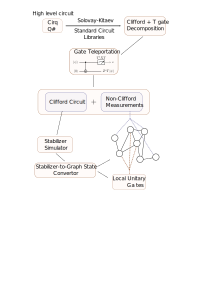

In [1]:
open("compiler.svg") do f
   display("image/svg+xml", read(f, String))
end

The compiler can be broken into the following stages

### Circuit Initialisation

1. Receives input of a Cirq Circuit instance. 
2. Generates a Clifford + T decomposition - At the moment we use Cirq's native decomposition methods. This does not support arbitarty rotations yet (Solovay-Kitaev in the workflow diagram). This feature can be added by integrating packages from Peter Selinger's group https://hackage.haskell.org/package/newsynth


### ICM decomposition (python package)

3. The package icm converts implements all T gates in the Clifford + T circuit using a CNOT and a measurement in a non-stabilizer basis. This is basically gate teleportation. This allows any circuit to be broken up into a stabilizer state initialisation followed by a round of non-stabilizer measurements. The technical challange being solved is that the compiler needs to keep track of where each qubit is being teleported during the decomposition process. This is done by adding flags to the circuit operations and qubits. 

### Stabalizer Simulator ( Julia - this is the guts of Jabalizer)

4. The stabilizer simulator is basically a wrapper around stim and it's Tableau simulator. The compiler will now simulate the pre-measurement Clifford part of the circuit by maping the circuit gates to stabilizer operations. 

### Graph conversion
5. The final stabilizer state is converted into a graph state using Jabalizer's inbuilt graph conversion algorithm. This is the algorithm specific graph state which will be used for benchmarking. 


### Import Jabalizer and PyCall which is a library to use python packages in Julia

In [2]:
using Jabalizer
using PyCall

### Import python packages

In [3]:
cirq = pyimport("cirq");

### Import ICM

 Right now the ICM package isn't installed during the build stage of Jabalizer. This is because there are some issues installing local python packages as opposed to ones from PyPI such as stim and cirq. This means we have to import ICM locally and this notebook will only work in the src/ directory.

In [4]:
# Adds script location to python search path
# This is required to import the icm module and to import saved circuit files
source = @__FILE__
circ_dir =  "cirq_circuits"

py"""
import os, sys
dirname = os.path.dirname($source)
sys.path.insert(0, dirname)
sys.path.insert(0, os.path.join(dirname, $circ_dir))
"""
icm = pyimport("icm");

## Example circuit decomposition

## Controlled-$V^{\dagger}$ with input $| 00 \rangle$

### import a circuit from file

In [5]:
# TODO: Enter correct directory
# cirq_circuit  = pyimport("cirq_cirquits");
cirq_circuit  = pyimport("cirq_cirquits/control_v");

In [6]:
circuit = cirq_circuit.build_circuit()

PyObject cirq.Circuit([
    cirq.Moment(
        (cirq.T**-1).on(cirq.GridQubit(0, 0)),
        cirq.H(cirq.GridQubit(1, 0)),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.GridQubit(1, 0), cirq.GridQubit(0, 0)),
    ),
    cirq.Moment(
        cirq.T(cirq.GridQubit(0, 0)),
        (cirq.T**-1).on(cirq.GridQubit(1, 0)),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.GridQubit(1, 0), cirq.GridQubit(0, 0)),
    ),
    cirq.Moment(
        cirq.H(cirq.GridQubit(1, 0)),
    ),
])

In [7]:
gates_to_decomp = [cirq.T, cirq.T^-1];

### ICM decomposition

The T gates in the above circuit are replaced by CNOTs to an ancilla and a measurement.

In [8]:
iicm_circuit = icm.iicm_circuit(circuit, gates_to_decomp)

PyObject cirq.Circuit([
    cirq.Moment(
        cirq.CNOT(cirq.NamedQubit('(0, 0)'), cirq.NamedQubit('›:anc_0')),
        cirq.H(cirq.NamedQubit('(1, 0)')),
    ),
    cirq.Moment(
        cirq.measure(cirq.NamedQubit('(0, 0)')),
        cirq.CNOT(cirq.NamedQubit('(1, 0)'), cirq.NamedQubit('›:anc_0')),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.NamedQubit('›:anc_0'), cirq.NamedQubit('›:anc_1')),
        cirq.CNOT(cirq.NamedQubit('(1, 0)'), cirq.NamedQubit('›:anc_2')),
    ),
    cirq.Moment(
        cirq.measure(cirq.NamedQubit('›:anc_0')),
        cirq.measure(cirq.NamedQubit('(1, 0)')),
        cirq.CNOT(cirq.NamedQubit('›:anc_2'), cirq.NamedQubit('›:anc_1')),
    ),
    cirq.Moment(
        cirq.H(cirq.NamedQubit('›:anc_2')),
    ),
])

### Stabilizer simulation.
The circuit gates excluding the final measurements are simulated using the stabilizer simulator (Jabalizer)

In [9]:
iicm_length = length(iicm_circuit.all_qubits())
state = Jabalizer.ZeroState(iicm_length);

print(state)

+ZIIII
+IZIII
+IIZII
+IIIZI
+IIIIZ



In [10]:
Jabalizer.execute_cirq_circuit(state, iicm_circuit)
print(state)

+ZIIII
+IXXIZ
+ZZZII
+IIZZX
+IZIIX



### Graph state conversion
The final stabilizer state is now converted into a an algorithm specific graph state. All stabilizer states can be converted to an equivalent graph state and the funtion `ToGraph` is used for this conversion. 

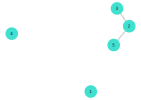

In [11]:
(g,A,seq) = Jabalizer.ToGraph(state)
Jabalizer.gplot(g)

ToGraph returns the graph state `g`

In [12]:
print(g)

+XIIII
+IXZIZ
+IZXII
+IIIXI
+IZIIX



The adjecency matrix defining the graph `A`. This is what will be used to benchmark the circuit,

In [13]:
display(A)

5×5 Array{Int64,2}:
 0  0  0  0  0
 0  0  1  0  1
 0  1  0  0  0
 0  0  0  0  0
 0  1  0  0  0

And a the sequence of local unitary operations required to convert the graph state back to the pre-measurement stabilizer output of the initial circuit `seq`

In [14]:
seq

3-element Array{Any,1}:
 ("H", 1)
 ("H", 3)
 ("H", 4)

## Control - $V^{\dagger}$ with input |+0>

In [15]:
circuit = cirq_circuit.build_circuit()

PyObject cirq.Circuit([
    cirq.Moment(
        (cirq.T**-1).on(cirq.GridQubit(0, 0)),
        cirq.H(cirq.GridQubit(1, 0)),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.GridQubit(1, 0), cirq.GridQubit(0, 0)),
    ),
    cirq.Moment(
        cirq.T(cirq.GridQubit(0, 0)),
        (cirq.T**-1).on(cirq.GridQubit(1, 0)),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.GridQubit(1, 0), cirq.GridQubit(0, 0)),
    ),
    cirq.Moment(
        cirq.H(cirq.GridQubit(1, 0)),
    ),
])

In [16]:
qubits = sort([q for q in  circuit.all_qubits()])

2-element Array{PyObject,1}:
 PyObject cirq.GridQubit(0, 0)
 PyObject cirq.GridQubit(1, 0)

In [17]:
circuit.insert(0, cirq.H(qubits[1]));

In [18]:
circuit

PyObject cirq.Circuit([
    cirq.Moment(
        cirq.H(cirq.GridQubit(0, 0)),
    ),
    cirq.Moment(
        (cirq.T**-1).on(cirq.GridQubit(0, 0)),
        cirq.H(cirq.GridQubit(1, 0)),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.GridQubit(1, 0), cirq.GridQubit(0, 0)),
    ),
    cirq.Moment(
        cirq.T(cirq.GridQubit(0, 0)),
        (cirq.T**-1).on(cirq.GridQubit(1, 0)),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.GridQubit(1, 0), cirq.GridQubit(0, 0)),
    ),
    cirq.Moment(
        cirq.H(cirq.GridQubit(1, 0)),
    ),
])

In [19]:
gates_to_decomp = [cirq.T, cirq.T^-1];

In [20]:
iicm_circuit = icm.iicm_circuit(circuit, gates_to_decomp)

PyObject cirq.Circuit([
    cirq.Moment(
        cirq.H(cirq.NamedQubit('(0, 0)')),
        cirq.H(cirq.NamedQubit('(1, 0)')),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.NamedQubit('(0, 0)'), cirq.NamedQubit('›:anc_3')),
    ),
    cirq.Moment(
        cirq.measure(cirq.NamedQubit('(0, 0)')),
        cirq.CNOT(cirq.NamedQubit('(1, 0)'), cirq.NamedQubit('›:anc_3')),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.NamedQubit('›:anc_3'), cirq.NamedQubit('›:anc_4')),
        cirq.CNOT(cirq.NamedQubit('(1, 0)'), cirq.NamedQubit('›:anc_5')),
    ),
    cirq.Moment(
        cirq.measure(cirq.NamedQubit('›:anc_3')),
        cirq.measure(cirq.NamedQubit('(1, 0)')),
        cirq.CNOT(cirq.NamedQubit('›:anc_5'), cirq.NamedQubit('›:anc_4')),
    ),
    cirq.Moment(
        cirq.H(cirq.NamedQubit('›:anc_5')),
    ),
])

In [21]:
iicm_length = length(iicm_circuit.all_qubits())
state = Jabalizer.ZeroState(iicm_length)
print(state)

+ZIIII
+IZIII
+IIZII
+IIIZI
+IIIIZ



In [22]:
Jabalizer.execute_cirq_circuit(state, iicm_circuit)
print(state)

+XIXXI
+IXXIZ
+ZZZII
+IIZZX
+IZIIX



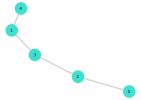

In [23]:
(g,A,seq) = Jabalizer.ToGraph(state)
Jabalizer.gplot(g)

In [24]:
seq

2-element Array{Any,1}:
 ("H", 3)
 ("H", 4)

## Toffolli gate with input |000>

In [25]:
qubits = [cirq.GridQubit(i, 1) for i in 0:2]

3-element Array{PyObject,1}:
 PyObject cirq.GridQubit(0, 1)
 PyObject cirq.GridQubit(1, 1)
 PyObject cirq.GridQubit(2, 1)

In [26]:
circuit = cirq.Circuit();

In [27]:
circuit.append(cirq.CCNOT(qubits...))

In [28]:
circuit

PyObject cirq.Circuit([
    cirq.Moment(
        cirq.TOFFOLI(cirq.GridQubit(0, 1), cirq.GridQubit(1, 1), cirq.GridQubit(2, 1)),
    ),
])

### Clifford + T decomposition using native cirq methods

In [29]:
ct_circuit = cirq.Circuit(cirq.decompose(circuit, keep=icm.keep_clifford))

PyObject cirq.Circuit([
    cirq.Moment(
        cirq.H(cirq.GridQubit(2, 1)),
        cirq.T(cirq.GridQubit(0, 1)),
        cirq.T(cirq.GridQubit(1, 1)),
    ),
    cirq.Moment(
        cirq.T(cirq.GridQubit(2, 1)),
        cirq.CNOT(cirq.GridQubit(0, 1), cirq.GridQubit(1, 1)),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.GridQubit(1, 1), cirq.GridQubit(2, 1)),
    ),
    cirq.Moment(
        (cirq.T**-1).on(cirq.GridQubit(1, 1)),
        cirq.T(cirq.GridQubit(2, 1)),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.GridQubit(0, 1), cirq.GridQubit(1, 1)),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.GridQubit(1, 1), cirq.GridQubit(2, 1)),
    ),
    cirq.Moment(
        (cirq.T**-1).on(cirq.GridQubit(2, 1)),
        cirq.CNOT(cirq.GridQubit(0, 1), cirq.GridQubit(1, 1)),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.GridQubit(1, 1), cirq.GridQubit(2, 1)),
    ),
    cirq.Moment(
        (cirq.T**-1).on(cirq.GridQubit(2, 1)),
        cirq.CNOT(cirq.GridQubit(0, 1), cirq.GridQubit(1, 1)),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.GridQubit(1, 1), cirq.GridQubit(2, 1)),
    ),
    cirq.Moment(
        cirq.H(cirq.GridQubit(2, 1)),
    ),
])

In [30]:
gates_to_decomp = [cirq.T, cirq.T^-1];
iicm_circuit = icm.iicm_circuit(ct_circuit, gates_to_decomp)

PyObject cirq.Circuit([
    cirq.Moment(
        cirq.H(cirq.NamedQubit('(2, 1)')),
        cirq.CNOT(cirq.NamedQubit('(0, 1)'), cirq.NamedQubit('›:anc_6')),
        cirq.CNOT(cirq.NamedQubit('(1, 1)'), cirq.NamedQubit('›:anc_7')),
    ),
    cirq.Moment(
        cirq.measure(cirq.NamedQubit('(0, 1)')),
        cirq.measure(cirq.NamedQubit('(1, 1)')),
        cirq.CNOT(cirq.NamedQubit('(2, 1)'), cirq.NamedQubit('›:anc_8')),
        cirq.CNOT(cirq.NamedQubit('›:anc_6'), cirq.NamedQubit('›:anc_7')),
    ),
    cirq.Moment(
        cirq.measure(cirq.NamedQubit('(2, 1)')),
        cirq.CNOT(cirq.NamedQubit('›:anc_7'), cirq.NamedQubit('›:anc_8')),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.NamedQubit('›:anc_7'), cirq.NamedQubit('›:anc_9')),
        cirq.CNOT(cirq.NamedQubit('›:anc_8'), cirq.NamedQubit('›:anc_10')),
    ),
    cirq.Moment(
        cirq.measure(cirq.NamedQubit('›:anc_7')),
        cirq.measure(cirq.NamedQubit('›:anc_8')),
        cirq.CNOT(cirq.NamedQubit('›:anc_6'), cirq.NamedQubit('›:anc_9')),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.NamedQubit('›:anc_9'), cirq.NamedQubit('›:anc_10')),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.NamedQubit('›:anc_10'), cirq.NamedQubit('›:anc_11')),
        cirq.CNOT(cirq.NamedQubit('›:anc_6'), cirq.NamedQubit('›:anc_9')),
    ),
    cirq.Moment(
        cirq.measure(cirq.NamedQubit('›:anc_10')),
        cirq.CNOT(cirq.NamedQubit('›:anc_9'), cirq.NamedQubit('›:anc_11')),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.NamedQubit('›:anc_11'), cirq.NamedQubit('›:anc_12')),
        cirq.CNOT(cirq.NamedQubit('›:anc_6'), cirq.NamedQubit('›:anc_9')),
    ),
    cirq.Moment(
        cirq.measure(cirq.NamedQubit('›:anc_11')),
        cirq.CNOT(cirq.NamedQubit('›:anc_9'), cirq.NamedQubit('›:anc_12')),
    ),
    cirq.Moment(
        cirq.H(cirq.NamedQubit('›:anc_12')),
    ),
])

In [31]:
iicm_length = length(iicm_circuit.all_qubits())
state = Jabalizer.ZeroState(iicm_length)
print(state)

+ZIIIIIIIII
+IZIIIIIIII
+IIZIIIIIII
+IIIZIIIIII
+IIIIZIIIII
+IIIIIZIIII
+IIIIIIZIII
+IIIIIIIZII
+IIIIIIIIZI
+IIIIIIIIIZ



In [32]:
Jabalizer.execute_cirq_circuit(state, iicm_circuit)
print(state)

+ZIIIIIIIII
+IZIIIIIIII
+IIXIIXIXXZ
+ZIIZIIIIII
+IZIZZIIIII
+IIZIZZIIII
+IIIZZIZIII
+IIIIIZZZII
+IIIZIIZZZI
+IIIIIIZIZX



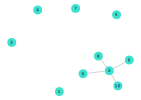

In [33]:
(g,A,seq) = Jabalizer.ToGraph(state)
Jabalizer.gplot(g)

In [34]:
seq

8-element Array{Any,1}:
 ("H", 1)
 ("H", 2)
 ("H", 4)
 ("H", 5)
 ("H", 6)
 ("H", 7)
 ("H", 8)
 ("H", 9)

## Toffoli with input |+00>

In [35]:
circuit = cirq.Circuit();
circuit.append(cirq.CCNOT(qubits...))
circuit.insert(0, cirq.H(qubits[1]));
circuit

PyObject cirq.Circuit([
    cirq.Moment(
        cirq.H(cirq.GridQubit(0, 1)),
    ),
    cirq.Moment(
        cirq.TOFFOLI(cirq.GridQubit(0, 1), cirq.GridQubit(1, 1), cirq.GridQubit(2, 1)),
    ),
])

In [36]:
ct_circuit = cirq.Circuit(cirq.decompose(circuit, keep=icm.keep_clifford))


PyObject cirq.Circuit([
    cirq.Moment(
        cirq.H(cirq.GridQubit(0, 1)),
        cirq.H(cirq.GridQubit(2, 1)),
        cirq.T(cirq.GridQubit(1, 1)),
    ),
    cirq.Moment(
        cirq.T(cirq.GridQubit(0, 1)),
        cirq.T(cirq.GridQubit(2, 1)),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.GridQubit(0, 1), cirq.GridQubit(1, 1)),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.GridQubit(1, 1), cirq.GridQubit(2, 1)),
    ),
    cirq.Moment(
        (cirq.T**-1).on(cirq.GridQubit(1, 1)),
        cirq.T(cirq.GridQubit(2, 1)),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.GridQubit(0, 1), cirq.GridQubit(1, 1)),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.GridQubit(1, 1), cirq.GridQubit(2, 1)),
    ),
    cirq.Moment(
        (cirq.T**-1).on(cirq.GridQubit(2, 1)),
        cirq.CNOT(cirq.GridQubit(0, 1), cirq.GridQubit(1, 1)),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.GridQubit(1, 1), cirq.GridQubit(2, 1)),
    ),
    cirq.Moment(
        (cirq.T**-1).on(cirq.GridQubit(2, 1)),
        cirq.CNOT(cirq.GridQubit(0, 1), cirq.GridQubit(1, 1)),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.GridQubit(1, 1), cirq.GridQubit(2, 1)),
    ),
    cirq.Moment(
        cirq.H(cirq.GridQubit(2, 1)),
    ),
])

In [37]:
gates_to_decomp = [cirq.T, cirq.T^-1];
iicm_circuit = icm.iicm_circuit(ct_circuit, gates_to_decomp)

PyObject cirq.Circuit([
    cirq.Moment(
        cirq.H(cirq.NamedQubit('(0, 1)')),
        cirq.H(cirq.NamedQubit('(2, 1)')),
        cirq.CNOT(cirq.NamedQubit('(1, 1)'), cirq.NamedQubit('›:anc_13')),
    ),
    cirq.Moment(
        cirq.measure(cirq.NamedQubit('(1, 1)')),
        cirq.CNOT(cirq.NamedQubit('(0, 1)'), cirq.NamedQubit('›:anc_14')),
        cirq.CNOT(cirq.NamedQubit('(2, 1)'), cirq.NamedQubit('›:anc_15')),
    ),
    cirq.Moment(
        cirq.measure(cirq.NamedQubit('(0, 1)')),
        cirq.measure(cirq.NamedQubit('(2, 1)')),
        cirq.CNOT(cirq.NamedQubit('›:anc_14'), cirq.NamedQubit('›:anc_13')),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.NamedQubit('›:anc_13'), cirq.NamedQubit('›:anc_15')),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.NamedQubit('›:anc_13'), cirq.NamedQubit('›:anc_16')),
        cirq.CNOT(cirq.NamedQubit('›:anc_15'), cirq.NamedQubit('›:anc_17')),
    ),
    cirq.Moment(
        cirq.measure(cirq.NamedQubit('›:anc_13')),
        cirq.measure(cirq.NamedQubit('›:anc_15')),
        cirq.CNOT(cirq.NamedQubit('›:anc_14'), cirq.NamedQubit('›:anc_16')),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.NamedQubit('›:anc_16'), cirq.NamedQubit('›:anc_17')),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.NamedQubit('›:anc_17'), cirq.NamedQubit('›:anc_18')),
        cirq.CNOT(cirq.NamedQubit('›:anc_14'), cirq.NamedQubit('›:anc_16')),
    ),
    cirq.Moment(
        cirq.measure(cirq.NamedQubit('›:anc_17')),
        cirq.CNOT(cirq.NamedQubit('›:anc_16'), cirq.NamedQubit('›:anc_18')),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.NamedQubit('›:anc_18'), cirq.NamedQubit('›:anc_19')),
        cirq.CNOT(cirq.NamedQubit('›:anc_14'), cirq.NamedQubit('›:anc_16')),
    ),
    cirq.Moment(
        cirq.measure(cirq.NamedQubit('›:anc_18')),
        cirq.CNOT(cirq.NamedQubit('›:anc_16'), cirq.NamedQubit('›:anc_19')),
    ),
    cirq.Moment(
        cirq.H(cirq.NamedQubit('›:anc_19')),
    ),
])

In [38]:
iicm_length = length(iicm_circuit.all_qubits())
state = Jabalizer.ZeroState(iicm_length)
Jabalizer.execute_cirq_circuit(state, iicm_circuit)
print(state)

+XIIXXXIXII
+IZIIIIIIII
+IIXIIXIXXZ
+IZIZZIIIII
+ZIIIZIIIII
+IIZZIZIIII
+IIIZZIZIII
+IIIIIZZZII
+IIIIZIZZZI
+IIIIIIZIZX



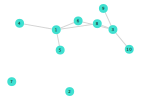

In [39]:
(g,A,seq) = Jabalizer.ToGraph(state)
Jabalizer.gplot(g)

In [40]:
seq

7-element Array{Any,1}:
 ("H", 2)
 ("H", 4)
 ("H", 5)
 ("H", 6)
 ("H", 7)
 ("H", 8)
 ("H", 9)

## Toffoli with input |++0>

In [41]:
circuit = cirq.Circuit();
circuit.append(cirq.CCNOT(qubits...))
circuit.insert(0, cirq.H(qubits[1]));
circuit.insert(0, cirq.H(qubits[2]));
circuit

PyObject cirq.Circuit([
    cirq.Moment(
        cirq.H(cirq.GridQubit(0, 1)),
        cirq.H(cirq.GridQubit(1, 1)),
    ),
    cirq.Moment(
        cirq.TOFFOLI(cirq.GridQubit(0, 1), cirq.GridQubit(1, 1), cirq.GridQubit(2, 1)),
    ),
])

In [42]:
ct_circuit = cirq.Circuit(cirq.decompose(circuit, keep=icm.keep_clifford))
gates_to_decomp = [cirq.T, cirq.T^-1];
iicm_circuit = icm.iicm_circuit(ct_circuit, gates_to_decomp)
iicm_length = length(iicm_circuit.all_qubits())
state = Jabalizer.ZeroState(iicm_length)
Jabalizer.execute_cirq_circuit(state, iicm_circuit)
print(state)

+XIIXXXIXII
+IXIIXXXIXI
+IIXIIXIXXZ
+ZIIZIIIIII
+IZIZZIIIII
+IIZIZZIIII
+IIIZZIZIII
+IIIIIZZZII
+IIIZIIZZZI
+IIIIIIZIZX



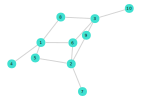

In [43]:
(g,A,seq) = Jabalizer.ToGraph(state)
Jabalizer.gplot(g)

In [44]:
iicm_circuit

PyObject cirq.Circuit([
    cirq.Moment(
        cirq.H(cirq.NamedQubit('(0, 1)')),
        cirq.H(cirq.NamedQubit('(1, 1)')),
        cirq.H(cirq.NamedQubit('(2, 1)')),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.NamedQubit('(0, 1)'), cirq.NamedQubit('›:anc_20')),
        cirq.CNOT(cirq.NamedQubit('(1, 1)'), cirq.NamedQubit('›:anc_21')),
        cirq.CNOT(cirq.NamedQubit('(2, 1)'), cirq.NamedQubit('›:anc_22')),
    ),
    cirq.Moment(
        cirq.measure(cirq.NamedQubit('(0, 1)')),
        cirq.measure(cirq.NamedQubit('(1, 1)')),
        cirq.measure(cirq.NamedQubit('(2, 1)')),
        cirq.CNOT(cirq.NamedQubit('›:anc_20'), cirq.NamedQubit('›:anc_21')),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.NamedQubit('›:anc_21'), cirq.NamedQubit('›:anc_22')),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.NamedQubit('›:anc_21'), cirq.NamedQubit('›:anc_23')),
        cirq.CNOT(cirq.NamedQubit('›:anc_22'), cirq.NamedQubit('›:anc_24')),
    ),
    cirq.Moment(
        cirq.measure(cirq.NamedQubit('›:anc_21')),
        cirq.measure(cirq.NamedQubit('›:anc_22')),
        cirq.CNOT(cirq.NamedQubit('›:anc_20'), cirq.NamedQubit('›:anc_23')),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.NamedQubit('›:anc_23'), cirq.NamedQubit('›:anc_24')),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.NamedQubit('›:anc_24'), cirq.NamedQubit('›:anc_25')),
        cirq.CNOT(cirq.NamedQubit('›:anc_20'), cirq.NamedQubit('›:anc_23')),
    ),
    cirq.Moment(
        cirq.measure(cirq.NamedQubit('›:anc_24')),
        cirq.CNOT(cirq.NamedQubit('›:anc_23'), cirq.NamedQubit('›:anc_25')),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.NamedQubit('›:anc_25'), cirq.NamedQubit('›:anc_26')),
        cirq.CNOT(cirq.NamedQubit('›:anc_20'), cirq.NamedQubit('›:anc_23')),
    ),
    cirq.Moment(
        cirq.measure(cirq.NamedQubit('›:anc_25')),
        cirq.CNOT(cirq.NamedQubit('›:anc_23'), cirq.NamedQubit('›:anc_26')),
    ),
    cirq.Moment(
        cirq.H(cirq.NamedQubit('›:anc_26')),
    ),
])

In [45]:
seq

6-element Array{Any,1}:
 ("H", 4)
 ("H", 5)
 ("H", 6)
 ("H", 7)
 ("H", 8)
 ("H", 9)